# 03. Phân Tích Phân Cụm Khách Hàng

Notebook này thực hiện và so sánh ba thuật toán phân cụm:
- **K-Means**: Phân cụm dựa trên phân hoạch
- **DBSCAN**: Phân cụm dựa trên mật độ  
- **Hierarchical Clustering**: Phân cụm phân cấp

Chúng ta sẽ phân tích các phân khúc khách hàng và xác định các cụm riêng biệt.

## 1. Thiết lập & Tải dữ liệu

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
print('Libraries loaded successfully!')

from sklearn.mixture import GaussianMixture
try:
    import umap.umap_ as umap
except ImportError:
    import subprocess
    import sys
    print('Installing umap-learn...')
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap.umap_ as umap
    print('umap-learn installed successfully.')


Libraries loaded successfully!


In [76]:
# Load scaled features
X = pd.read_csv('../data/processed/customer_features_scaled.csv')

# Remove CustomerID column and clean data
if 'CustomerID' in X.columns:
    customer_ids = X['CustomerID'].copy()
    X = X.drop('CustomerID', axis=1)
else:
    customer_ids = None

# Remove rows with non-numeric values
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()

print(f'Data shape: {X.shape}')
print(f'Features ({len(X.columns)} total):')
print(X.columns.tolist())
print(f'\nBasic statistics:')
print(X.describe().round(3))

Data shape: (3920, 16)
Features (16 total):
['Sum_Quantity', 'Mean_UnitPrice', 'Mean_TotalPrice', 'Sum_TotalPrice', 'Count_Invoice', 'Count_Stock', 'Mean_InvoiceCountPerStock', 'Mean_StockCountPerInvoice', 'Mean_UnitPriceMeanPerInvoice', 'Mean_QuantitySumPerInvoice', 'Mean_TotalPriceMeanPerInvoice', 'Mean_TotalPriceSumPerInvoice', 'Mean_UnitPriceMeanPerStock', 'Mean_QuantitySumPerStock', 'Mean_TotalPriceMeanPerStock', 'Mean_TotalPriceSumPerStock']

Basic statistics:
       Sum_Quantity  Mean_UnitPrice  Mean_TotalPrice  Sum_TotalPrice  \
count      3920.000        3920.000         3920.000        3920.000   
mean         -0.001          -0.000            0.000          -0.001   
std           0.997           1.000            1.000           0.998   
min          -3.897          -5.067           -2.990          -5.045   
25%          -0.659          -0.553           -0.478          -0.650   
50%          -0.030           0.040            0.077           0.003   
75%           0.666      

## 2. Phân Tích Phân Cụm K-Means

K-Means chia dữ liệu thành k cụm bằng cách giảm thiểu phương sai trong cụm.

In [77]:
# K-Means with different k values
K_range = range(2, 11)
inertias = []
silhouettes_km = []
davies_bouldin_km = []
calinski_km = []

print('K-Means Clustering Analysis')
print('='*50)

for k in K_range:
    print(f'Processing K={k}...', end=' ')
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X)
    
    inertias.append(kmeans.inertia_)
    silhouettes_km.append(silhouette_score(X, kmeans.labels_))
    davies_bouldin_km.append(davies_bouldin_score(X, kmeans.labels_))
    calinski_km.append(calinski_harabasz_score(X, kmeans.labels_))
    print(f'Silhouette: {silhouettes_km[-1]:.3f}')

optimal_k = K_range[np.argmax(silhouettes_km)]
print(f'\nOptimal K (by Silhouette): {optimal_k}')

K-Means Clustering Analysis
Processing K=2... Silhouette: 0.208
Processing K=3... Silhouette: 0.236
Processing K=4... Silhouette: 0.239
Processing K=5... Silhouette: 0.229
Processing K=6... Silhouette: 0.198
Processing K=7... Silhouette: 0.190
Processing K=8... Silhouette: 0.198
Processing K=9... Silhouette: 0.192
Processing K=10... Silhouette: 0.180

Optimal K (by Silhouette): 4


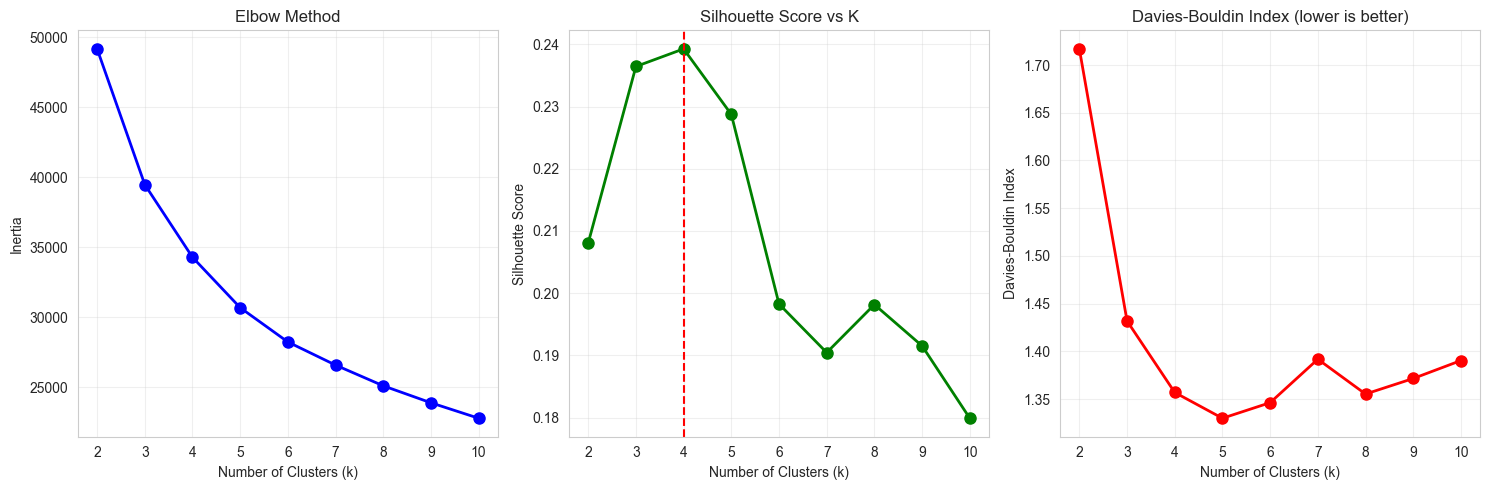

In [78]:
# Plot K-Means evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouettes_km, 'go-', linewidth=2, markersize=8)
axes[1].axvline(optimal_k, color='red', linestyle='--')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs K')
axes[1].grid(True, alpha=0.3)

axes[2].plot(K_range, davies_bouldin_km, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index (lower is better)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/kmeans_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [79]:
# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
kmeans_labels = kmeans_final.fit_predict(X)

print(f'K-Means Results (k={optimal_k})')
print(f'  Silhouette Score: {silhouette_score(X, kmeans_labels):.4f}')
print(f'  Davies-Bouldin Index: {davies_bouldin_score(X, kmeans_labels):.4f}')
print(f'  Calinski-Harabasz Index: {calinski_harabasz_score(X, kmeans_labels):.4f}')

K-Means Results (k=4)
  Silhouette Score: 0.2393
  Davies-Bouldin Index: 1.3569
  Calinski-Harabasz Index: 1078.5191


## 3. Phân Tích Phân Cụm DBSCAN

DBSCAN là thuật toán phân cụm dựa trên mật độ, nhóm các điểm nằm sát nhau lại.

In [80]:
# DBSCAN with different parameters
eps_range = np.arange(0.5, 3.5, 0.5)
min_samples_range = [3, 5, 10, 15]

print('DBSCAN Clustering Analysis')
print('='*50)

dbscan_results = {}
best_dbscan_score = -1
best_dbscan_params = None

for eps in eps_range:
    for min_samples in min_samples_range:
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            if n_clusters > 1 and n_noise < len(X) * 0.5:  # At least 2 clusters, less than 50% noise
                non_noise_mask = labels != -1
                if sum(non_noise_mask) > 1:
                    X_filtered = X[non_noise_mask].values
                    labels_filtered = labels[non_noise_mask]
                    
                    sil = silhouette_score(X_filtered, labels_filtered)
                    
                    key = f'eps={eps:.1f}_ms={min_samples}'
                    dbscan_results[key] = {
                        'labels': labels,
                        'n_clusters': n_clusters,
                        'n_noise': n_noise,
                        'silhouette': sil,
                        'eps': eps,
                        'min_samples': min_samples
                    }
                    
                    if sil > best_dbscan_score:
                        best_dbscan_score = sil
                        best_dbscan_params = key
                        dbscan_labels = labels.copy()
        except Exception as e:
            continue

if best_dbscan_params:
    print(f'Best DBSCAN configuration: {best_dbscan_params}')
    print(f'  Clusters: {dbscan_results[best_dbscan_params]["n_clusters"]}')
    print(f'  Noise points: {dbscan_results[best_dbscan_params]["n_noise"]}')
    print(f'  Silhouette Score: {best_dbscan_score:.4f}')
else:
    print('No valid DBSCAN configuration found. Using default...')
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)

DBSCAN Clustering Analysis
Best DBSCAN configuration: eps=3.0_ms=3
  Clusters: 2
  Noise points: 16
  Silhouette Score: 0.5188


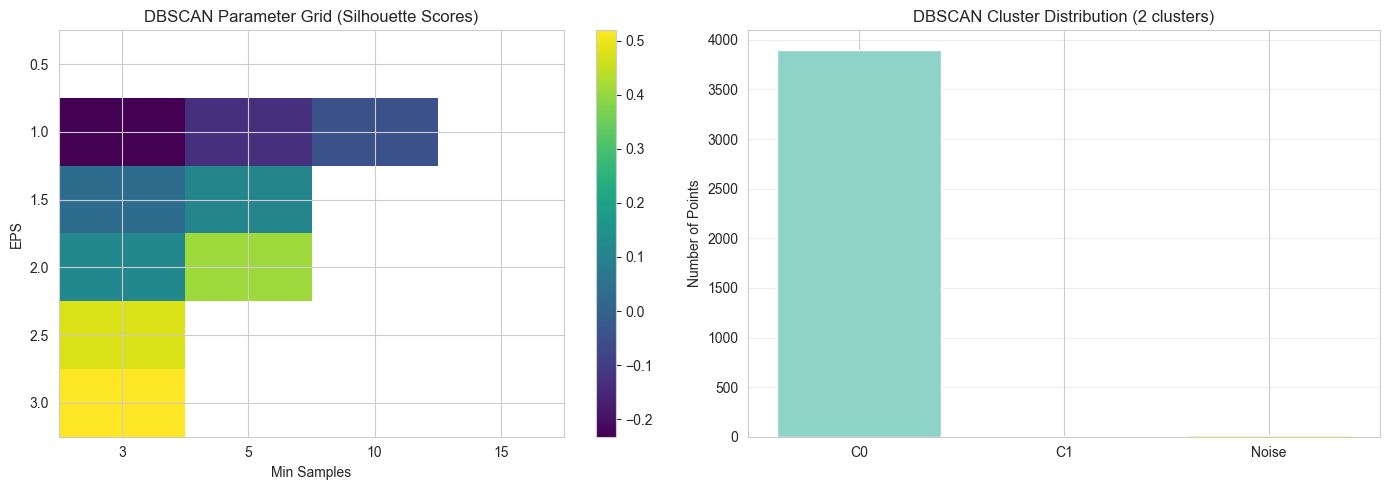

In [81]:
# Visualize DBSCAN results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Parameter grid heatmap
if dbscan_results:
    scores_grid = np.zeros((len(eps_range), len(min_samples_range)))
    for i, eps in enumerate(eps_range):
        for j, ms in enumerate(min_samples_range):
            key = f'eps={eps:.1f}_ms={ms}'
            if key in dbscan_results:
                scores_grid[i, j] = dbscan_results[key]['silhouette']
            else:
                scores_grid[i, j] = np.nan
    
    im = axes[0].imshow(scores_grid, cmap='viridis', aspect='auto')
    axes[0].set_xticks(range(len(min_samples_range)))
    axes[0].set_yticks(range(len(eps_range)))
    axes[0].set_xticklabels(min_samples_range)
    axes[0].set_yticklabels([f'{x:.1f}' for x in eps_range])
    axes[0].set_xlabel('Min Samples')
    axes[0].set_ylabel('EPS')
    axes[0].set_title('DBSCAN Parameter Grid (Silhouette Scores)')
    plt.colorbar(im, ax=axes[0])

# Cluster distribution
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
cluster_counts = {}
for i in range(n_clusters_dbscan):
    cluster_counts[f'C{i}'] = sum(dbscan_labels == i)
cluster_counts['Noise'] = sum(dbscan_labels == -1)

axes[1].bar(cluster_counts.keys(), cluster_counts.values(), 
           color=plt.cm.Set3(np.linspace(0, 1, len(cluster_counts))))
axes[1].set_ylabel('Number of Points')
axes[1].set_title(f'DBSCAN Cluster Distribution ({n_clusters_dbscan} clusters)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/dbscan_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Phân Tích Phân Cụm Phân Cấp

Phân cụm phân cấp tạo ra cấu trúc hình cây của các cụm lồng nhau.

In [82]:
# Hierarchical clustering with different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
n_clusters_range_hier = range(2, 11)

print('Hierarchical Clustering Analysis')
print('='*50)

hierarchical_results = {}
best_hier_score = -1
best_hier_config = None

for linkage_method in linkage_methods:
    print(f'\nLinkage: {linkage_method}')
    for n_clusters in n_clusters_range_hier:
        try:
            model = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage_method
            )
            labels = model.fit_predict(X)
            
            if len(set(labels)) > 1:
                sil = silhouette_score(X, labels)
                db = davies_bouldin_score(X, labels)
                
                key = f'link={linkage_method}_n={n_clusters}'
                hierarchical_results[key] = {
                    'labels': labels,
                    'n_clusters': n_clusters,
                    'linkage': linkage_method,
                    'silhouette': sil,
                    'davies_bouldin': db
                }
                
                if sil > best_hier_score:
                    best_hier_score = sil
                    best_hier_config = key
                    hierarchical_labels = labels.copy()
                    
                print(f'  n={n_clusters}: Silhouette={sil:.4f}')
        except Exception as e:
            continue

print(f'\nBest Hierarchical config: {best_hier_config}')
print(f'  Silhouette Score: {best_hier_score:.4f}')

Hierarchical Clustering Analysis

Linkage: ward
  n=2: Silhouette=0.2012
  n=3: Silhouette=0.1984
  n=4: Silhouette=0.1675
  n=5: Silhouette=0.1782
  n=6: Silhouette=0.1542
  n=7: Silhouette=0.1302
  n=8: Silhouette=0.1310
  n=9: Silhouette=0.1262
  n=10: Silhouette=0.1325

Linkage: complete
  n=2: Silhouette=0.0782
  n=3: Silhouette=0.0704
  n=4: Silhouette=0.0809
  n=5: Silhouette=0.0717
  n=6: Silhouette=0.0698
  n=7: Silhouette=0.1252
  n=8: Silhouette=0.1248
  n=9: Silhouette=0.1213
  n=10: Silhouette=0.1226

Linkage: average
  n=2: Silhouette=0.6328
  n=3: Silhouette=0.5248
  n=4: Silhouette=0.4975
  n=5: Silhouette=0.4019
  n=6: Silhouette=0.3357
  n=7: Silhouette=0.3051
  n=8: Silhouette=0.2721
  n=9: Silhouette=0.2717
  n=10: Silhouette=0.1941

Linkage: single
  n=2: Silhouette=0.6639
  n=3: Silhouette=0.5904
  n=4: Silhouette=0.5384
  n=5: Silhouette=0.5118
  n=6: Silhouette=0.4173
  n=7: Silhouette=0.2999
  n=8: Silhouette=0.2991
  n=9: Silhouette=0.2702
  n=10: Silhouette=0

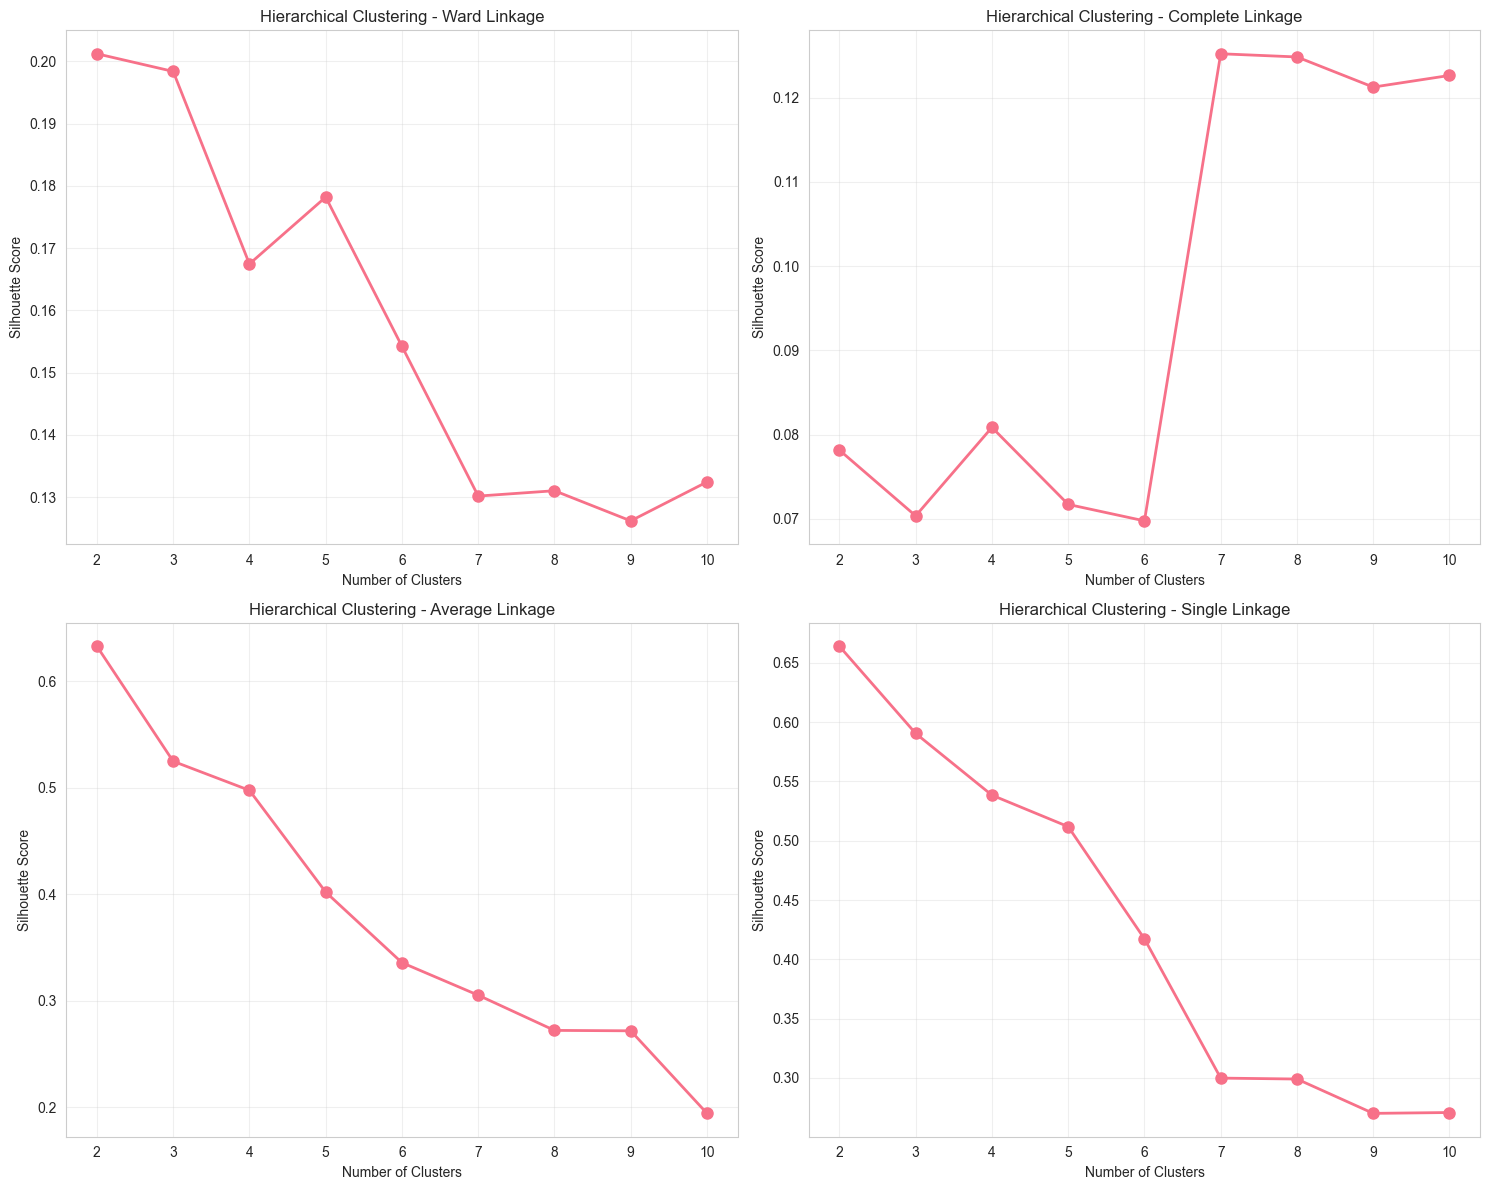

In [83]:
# Visualize Hierarchical clustering results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot silhouette scores for each linkage method
for idx, linkage_method in enumerate(linkage_methods):
    ax = axes[idx // 2, idx % 2]
    
    scores = []
    for n in n_clusters_range_hier:
        key = f'link={linkage_method}_n={n}'
        if key in hierarchical_results:
            scores.append(hierarchical_results[key]['silhouette'])
        else:
            scores.append(0)
    
    ax.plot(n_clusters_range_hier, scores, 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Score')
    ax.set_title(f'Hierarchical Clustering - {linkage_method.capitalize()} Linkage')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/hierarchical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

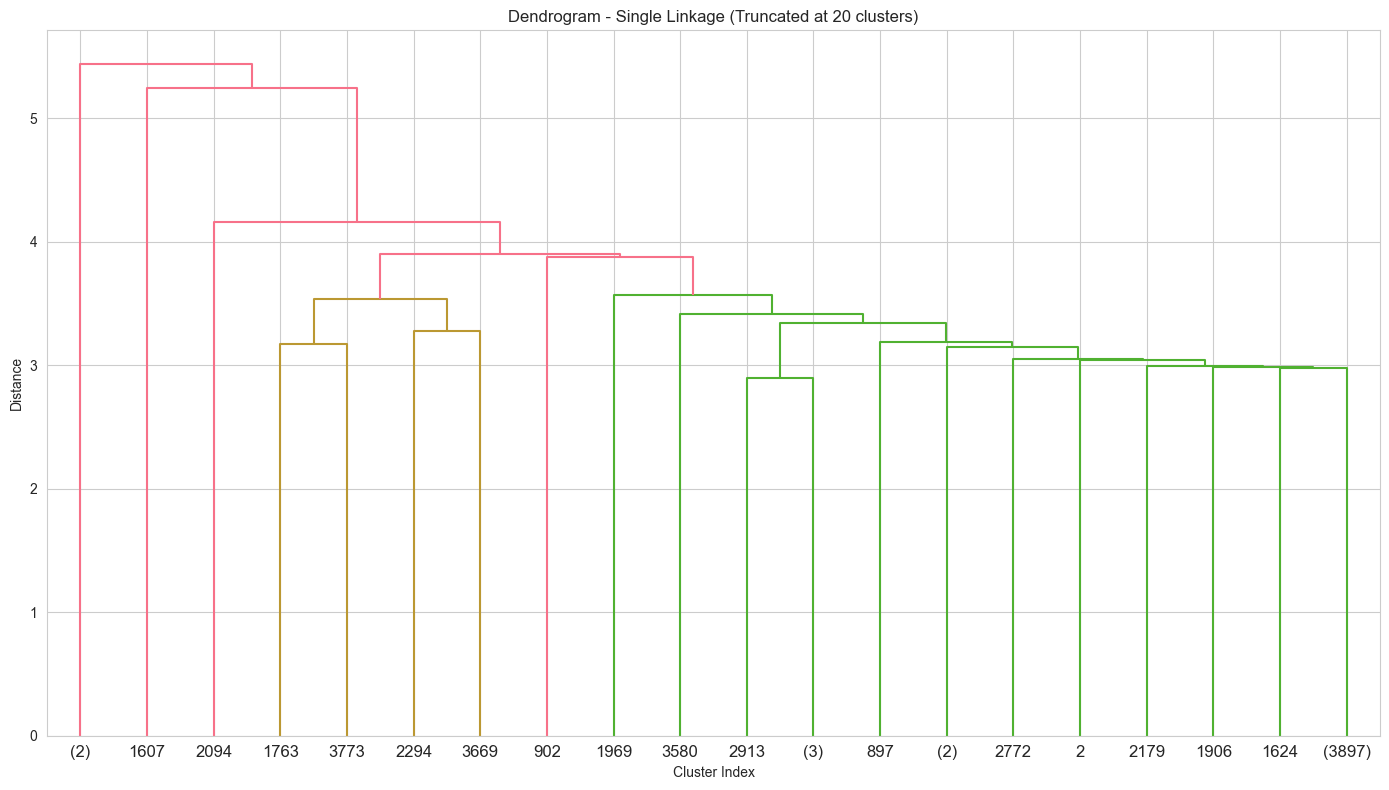

In [84]:
# Create dendrogram for best hierarchical configuration
if best_hier_config:
    best_config = hierarchical_results[best_hier_config]
    linkage_method = best_config['linkage']
    n_clusters = best_config['n_clusters']
    
    # Compute linkage matrix
    Z = linkage(X.values, method=linkage_method)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    dendrogram(Z, ax=ax, truncate_mode='lastp', p=20)
    ax.set_title(f'Dendrogram - {linkage_method.capitalize()} Linkage (Truncated at 20 clusters)')
    ax.set_xlabel('Cluster Index')
    ax.set_ylabel('Distance')
    plt.tight_layout()
    plt.savefig('../results/figures/dendrogram.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Algorithm Comparison

In [85]:
# Create comparison dataframe
comparison_data = {
    'Algorithm': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Silhouette': [
        silhouette_score(X, kmeans_labels),
        silhouette_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(set(dbscan_labels)) > 1 else 0,
        silhouette_score(X, hierarchical_labels)
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X, kmeans_labels),
        davies_bouldin_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(set(dbscan_labels)) > 1 else 0,
        davies_bouldin_score(X, hierarchical_labels)
    ],
    'Clusters': [
        len(set(kmeans_labels)),
        len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0),
        len(set(hierarchical_labels))
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

      Algorithm  Silhouette  Davies-Bouldin  Clusters
0       K-Means    0.239261        1.356916         4
1        DBSCAN    0.518760        0.530348         2
2  Hierarchical    0.663856        0.316446         2


In [86]:
# Save cluster assignments from all algorithms
results_df = pd.DataFrame({
    'Index': range(len(X))
})

# Add cluster labels from each algorithm
results_df['KMeans_Cluster'] = kmeans_labels
results_df['DBSCAN_Cluster'] = dbscan_labels
results_df['Hierarchical_Cluster'] = hierarchical_labels
if 'gmm_labels' in locals():
    results_df['GMM_Cluster'] = gmm_labels

# Add PCA coordinates
if 'X_pca' in locals():
    results_df['PCA_1'] = X_pca[:, 0]
    results_df['PCA_2'] = X_pca[:, 1]

# Add UMAP coordinates
if 'X_umap' in locals():
    results_df['UMAP_1'] = X_umap[:, 0]
    results_df['UMAP_2'] = X_umap[:, 1]

# Save full results
results_df.to_csv('../results/cluster_assignments.csv', index=False)
print(f'Cluster assignments saved: {len(results_df)} records')

# Create summary
print('\n' + '='*70)
print('CLUSTERING SUMMARY')
print('='*70)
print(f'Total customers: {len(X):,}')
print(f'Total features: {len(X.columns)}')
print(f'\nK-Means: {optimal_k} clusters')
try:
    print(f'DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} clusters + {sum(dbscan_labels == -1)} noise points')
except: pass
try:
    print(f'Hierarchical: {hierarchical_results[best_hier_config]["n_clusters"]} clusters')
except: pass
try:
    print(f'GMM: {optimal_n_gmm} clusters')
except: pass
print('='*70)

Cluster assignments saved: 3920 records

CLUSTERING SUMMARY
Total customers: 3,920
Total features: 16

K-Means: 4 clusters
DBSCAN: 2 clusters + 16 noise points
Hierarchical: 2 clusters
GMM: 10 clusters


In [87]:
# Tạo DataFrame so sánh các thuật toán
comparison_data = {
    'Algorithm': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Silhouette': [
        silhouette_score(X, kmeans_labels),
        silhouette_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(set(dbscan_labels)) > 1 else 0,
        silhouette_score(X, hierarchical_labels)
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X, kmeans_labels),
        davies_bouldin_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(set(dbscan_labels)) > 1 else 0,
        davies_bouldin_score(X, hierarchical_labels)
    ],
    'Clusters': [
        len(set(kmeans_labels)),
        len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0),
        len(set(hierarchical_labels))
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print('\nBảng so sánh các thuật toán:')
print(comparison_df)


Bảng so sánh các thuật toán:
      Algorithm  Silhouette  Davies-Bouldin  Clusters
0       K-Means    0.239261        1.356916         4
1        DBSCAN    0.518760        0.530348         2
2  Hierarchical    0.663856        0.316446         2


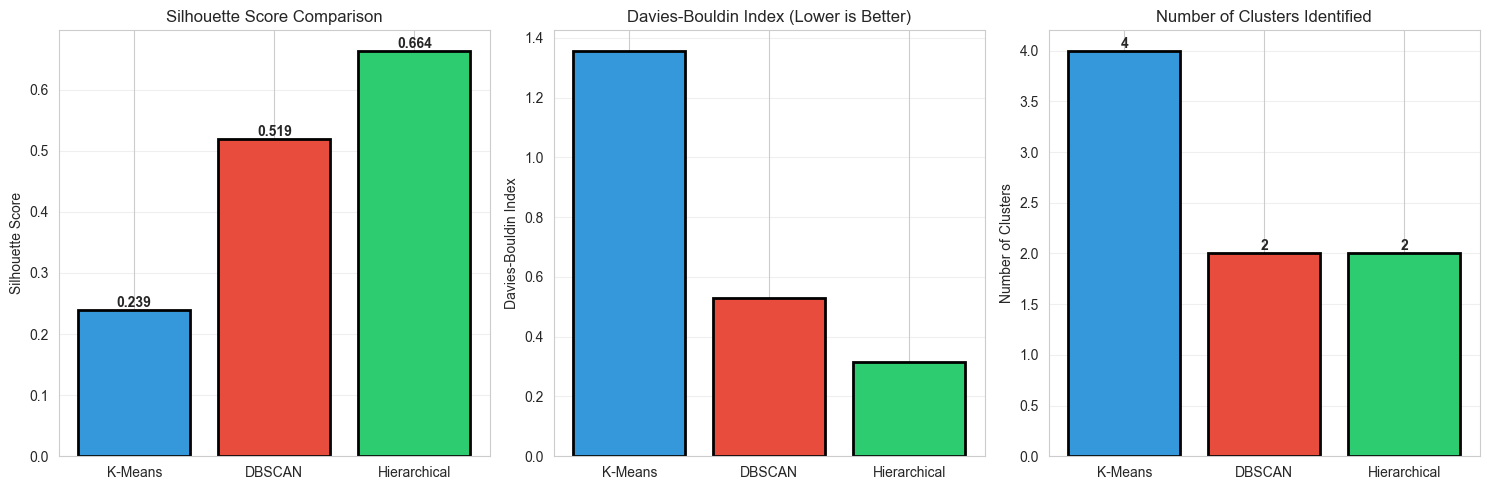

In [88]:
# Visualization comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

algorithms = ['K-Means', 'DBSCAN', 'Hierarchical']
silhouette_scores = comparison_df['Silhouette'].values
davies_bouldin_scores = comparison_df['Davies-Bouldin'].values
n_clusters_list = comparison_df['Clusters'].values

# Silhouette score comparison
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[0].bar(algorithms, silhouette_scores, color=colors, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score Comparison')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(silhouette_scores):
    axes[0].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Davies-Bouldin index (lower is better)
axes[1].bar(algorithms, davies_bouldin_scores, color=colors, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1].grid(True, alpha=0.3, axis='y')

# Number of clusters
axes[2].bar(algorithms, n_clusters_list, color=colors, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Number of Clusters')
axes[2].set_title('Number of Clusters Identified')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(n_clusters_list):
    axes[2].text(i, v, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Trực Quan Hóa PCA of All Algorithms

In [89]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f'PCA Explained Variance:')
print(f'  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%')
print(f'  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%')
print(f'  Total: {pca.explained_variance_ratio_.sum()*100:.2f}%')

PCA Explained Variance:
  PC1: 36.10%
  PC2: 30.33%
  Total: 66.44%


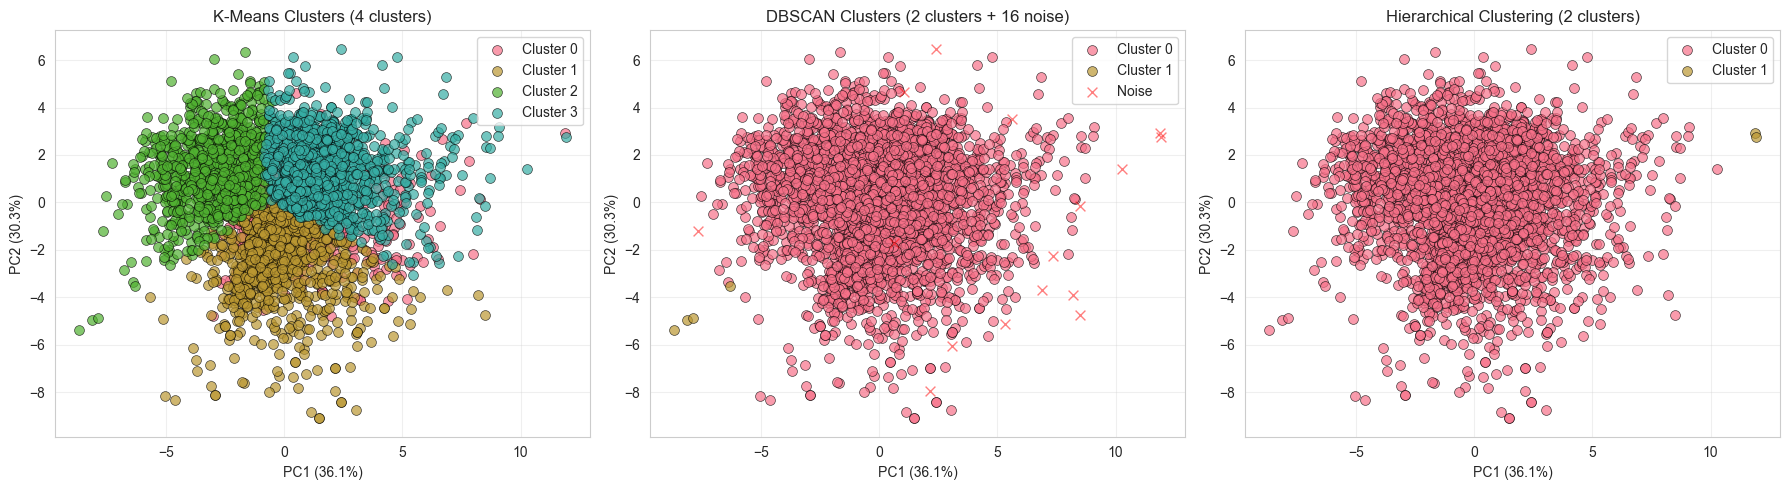

In [90]:
# Visualize all three algorithms in PCA space
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
for cluster in sorted(set(kmeans_labels)):
    mask = kmeans_labels == cluster
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=f'Cluster {cluster}', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title(f'K-Means Clusters ({optimal_k} clusters)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# DBSCAN
noise_mask = dbscan_labels == -1
for cluster in sorted(set(dbscan_labels)):
    if cluster == -1:
        continue
    mask = dbscan_labels == cluster
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=f'Cluster {cluster}', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
if noise_mask.sum() > 0:
    axes[1].scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], 
                   label='Noise', s=50, alpha=0.5, c='red', marker='x', linewidth=1)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title(f'DBSCAN Clusters ({len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} clusters + {noise_mask.sum()} noise)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Hierarchical
for cluster in sorted(set(hierarchical_labels)):
    mask = hierarchical_labels == cluster
    axes[2].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=f'Cluster {cluster}', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[2].set_title(f'Hierarchical Clustering ({hierarchical_results[best_hier_config]["n_clusters"]} clusters)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/clustering_comparison_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Phân Tích Gaussian Mixture Models (GMM)

GMM là mô hình xác suất giả định rằng tất cả các điểm dữ liệu được tạo ra từ hỗn hợp của một số hữu hạn các phân phối Gaussian với các tham số chưa biết.


GMM Clustering Analysis
Processing n=2... BIC: -70760, AIC: -72673
Processing n=3... BIC: -95654, AIC: -98527
Processing n=4... BIC: -103390, AIC: -107223
Processing n=5... BIC: -111368, AIC: -116161
Processing n=6... BIC: -115212, AIC: -120965
Processing n=7... BIC: -123731, AIC: -130444
Processing n=8... BIC: -130412, AIC: -138085
Processing n=9... BIC: -129825, AIC: -138458
Processing n=10... BIC: -140318, AIC: -149911

Optimal Components (by BIC): 10


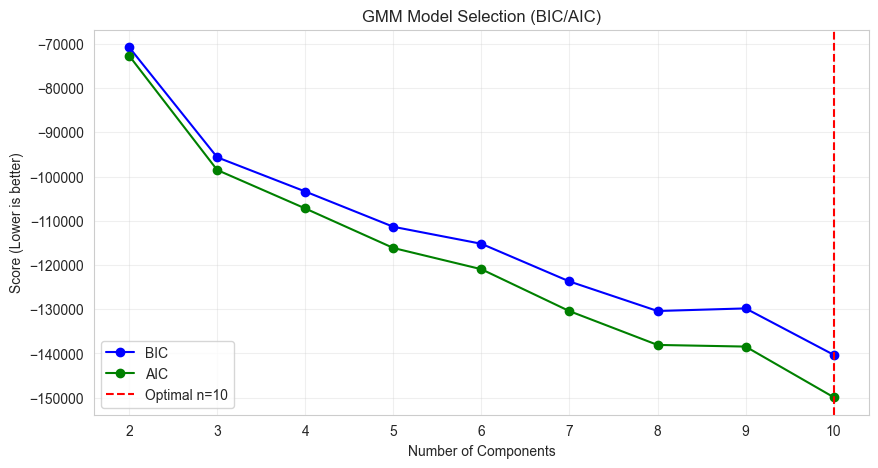

In [91]:
# GMM Analysis
n_components_range = range(2, 11)
bics = []
aics = []

print('GMM Clustering Analysis')
print('='*50)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=5)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    aics.append(gmm.aic(X))
    print(f'Processing n={n}... BIC: {bics[-1]:.0f}, AIC: {aics[-1]:.0f}')

# Optimal n by BIC (lower is better)
optimal_n_gmm = n_components_range[np.argmin(bics)]
print(f'\nOptimal Components (by BIC): {optimal_n_gmm}')

# Fit final GMM
gmm_final = GaussianMixture(n_components=optimal_n_gmm, random_state=42, n_init=10)
gmm_labels = gmm_final.fit_predict(X)
gmm_proba = gmm_final.predict_proba(X)

# Plot BIC/AIC
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bics, 'bo-', label='BIC')
plt.plot(n_components_range, aics, 'go-', label='AIC')
plt.axvline(optimal_n_gmm, color='red', linestyle='--', label=f'Optimal n={optimal_n_gmm}')
plt.xlabel('Number of Components')
plt.ylabel('Score (Lower is better)')
plt.title('GMM Model Selection (BIC/AIC)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 6. Trực Quan Hóa Với UMAP

UMAP (Uniform Manifold Approximation and Projection) là kỹ thuật giảm chiều dữ liệu mạnh mẽ, thường tốt hơn PCA trong việc bảo tồn cấu trúc cục bộ và toàn cục của dữ liệu.


## 7. Lưu Kết Quả

In [92]:
# Save cluster assignments from all algorithms
results_df = pd.DataFrame({
    'Index': range(len(X))
})

# Add cluster labels from each algorithm
results_df['KMeans_Cluster'] = kmeans_labels
results_df['DBSCAN_Cluster'] = dbscan_labels
results_df['Hierarchical_Cluster'] = hierarchical_labels

# Add PCA coordinates
results_df['PCA_1'] = X_pca[:, 0]
results_df['PCA_2'] = X_pca[:, 1]

# Save full results
results_df.to_csv('../results/cluster_assignments.csv', index=False)
print(f'Cluster assignments saved: {len(results_df)} records')

# Create summary
print('\n' + '='*70)
print('CLUSTERING SUMMARY')
print('='*70)
print(f'Total customers: {len(X):,}')
print(f'Total features: {len(X.columns)}')
print(f'\nK-Means: {optimal_k} clusters')
print(f'DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)} clusters + {sum(dbscan_labels == -1)} noise points')
print(f'Hierarchical: {hierarchical_results[best_hier_config]["n_clusters"]} clusters')
print('='*70)

Cluster assignments saved: 3920 records

CLUSTERING SUMMARY
Total customers: 3,920
Total features: 16

K-Means: 4 clusters
DBSCAN: 2 clusters + 16 noise points
Hierarchical: 2 clusters
